# Load Images

## Import and preview hrHSI

In [ ]:
from preprocessing import preprocessHrHSI

# Specify paths
hr_path = "data/FX10/"
hr_mtx_path = 'data/FX10/2D/hrHSI_matrix.npy'
hr_dist_path = 'data/FX10/2D/hrHSI_dist.npy'

# Load and preprocess file
hr_file = preprocessHrHSI(hr_path + "leaf_test1.hdf5", hr_mtx_path, hr_dist_path)

# Store to variables
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

In [ ]:
from preprocessing import previewHrHSI

# Select pixel and spectrum to highlight
hr_selected_pixel = (650, 650)
hr_selected_spectrum = 120

# Preview
previewHrHSI(hr_img, hr_wavelengths, hr_selected_pixel, hr_selected_spectrum)

## Import and preview snapshot

In [ ]:
from preprocessing import preprocessSnapshot

# Specify paths
ss_path = "data/Snapshot/leaf_test_processed/leaf_test/"
ss_mtx_path = 'data/Snapshot/2D/snapshot_matrix.npy'
ss_dist_path = 'data/Snapshot/2D/snapshot_dist.npy'

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path)

# Store to variables
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]

In [ ]:
from preprocessing import previewSnapshot

# Select pixel and spectrum to highlight
ss_selected_pixel = (75, 210)
ss_selected_spectrum = 20

# Preview
previewSnapshot(ss_img, ss_wavelengths, ss_selected_pixel, ss_selected_spectrum)

## Compare hrHSI and Snapshot

In [ ]:
from preprocessing import preprocessHrHSI

# Specify paths
# hr_path = "data/FX10/align"
hr_path = "data/FX10/spelt3_l"
hr_mtx_path = 'data/FX10/2D/hrHSI_matrix.npy'
hr_dist_path = 'data/FX10/2D/hrHSI_dist.npy'

# Load and preprocess file
hr_file = preprocessHrHSI(hr_path + ".hdf5", hr_mtx_path, hr_dist_path)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

In [ ]:
from preprocessing import preprocessSnapshot

# Specify paths
ss_path = "data/Snapshot/spelt_l_processed/spelt3/"
# ss_path = "data/Snapshot/align_processed/align/"
ss_mtx_path = 'data/Snapshot/2D/snapshot_matrix.npy'
ss_dist_path = 'data/Snapshot/2D/snapshot_dist.npy'

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path)
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]

In [ ]:
from align_images import align_images, plot_image_comparison
from skimage import transform

# # Set offsets and rotations
# x_off = (97, 1010)   # Full: (0, 1084)
# y_off = (188, 720)   # Full: (0, 1015)
# hr_rot = -0.2
# ss_rot = 0

# Set offsets and rotations
x_off = (104, 1017)   # Full: (0, 1084)
y_off = (189, 720)   # Full: (0, 1015)
rot = -0.2
shear = 0.017


# Align images
hr_img_al, ss_img_al = align_images(hr_img=hr_img,
                                    ss_img=ss_img, 
                                    x_off=x_off, 
                                    y_off=y_off,
                                    rot=rot,
                                    shear=shear)




# Plot image comparison
plot_image_comparison(hr_img=hr_img_al, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img_al, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(110, 240),
                      selected_spectrum=715)

In [ ]:
# Compare resolutions
print("HrHSI1:", hr_img_al.shape)
print("Shapshot:", ss_img_al.shape)
print("\n")

# Compare aspect ratio
print("HrHSI:", round(hr_img_al.shape[1] / hr_img_al.shape[0], 2))
print("Shapshot:", round(ss_img_al.shape[1] / ss_img_al.shape[0], 2))

## Select the 24 wavelengths present in the snapshot

# Explore processed files

In [ ]:
# Read numpy file
import numpy as np
hr_img_2 = np.load('data/Processed/spelt1_l_s.npy')

# Plot image
import matplotlib.pyplot as plt
plt.imshow(hr_img_2[:, :, 3])
plt.show()

# Shape
print(hr_img_2.shape)

# Save as b&w image
import cv2 as cv
cv.imwrite("data/Processed/hrtest.jpg", hr_img_2[:, :, 10] * 255)

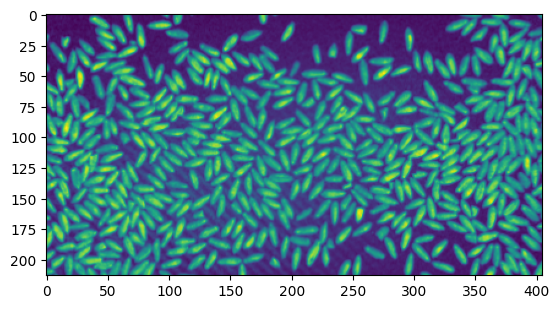

In [14]:
from preprocessing import preprocessSnapshot
import matplotlib.pyplot as plt

# Specify paths
ss_path = "data/Snapshot/spelt_s3/"
# ss_path = "calibrations/Snapshot/spelt_processed/spelt1/"
ss_mtx_path = 'data/Snapshot/2D/snapshot_matrix.npy'
ss_dist_path = 'data/Snapshot/2D/snapshot_dist.npy'

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path)

# Store to variables
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]


plt.imshow(ss_img[:, :, 3])
plt.show()

# Save as b&w image
import cv2 as cv
# cv.imwrite("data/Processed/sstest.jpg", ss_img[:, :, 10] * 255)

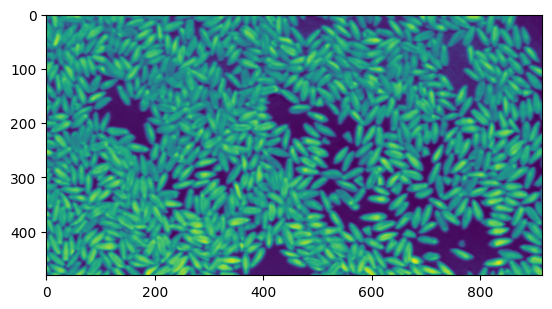

True

In [7]:
from preprocessing import preprocessFullHSI
import matplotlib.pyplot as plt

# Load 1 hdf5 file as test
hdf5_files = 'data/FX10/spelt_m1.hdf5'

# Specify camera calibration files
mtx_path = 'data/FX10/2D/hrHSI_matrix.npy'
dist_path = 'data/FX10/2D/hrHSI_dist.npy'

# Snapshot dimensions and wavelengths
ss_shape = (213, 405, 24)
ss_wavelengths = [667, 679, 691, 703, 715, 
                  727, 739, 751, 763, 775, 
                  787, 799, 811, 823, 835, 
                  847, 859, 871, 883, 895, 
                  907, 919, 931, 943]


# Set offsets and rotations
x_off = (104, 1019)   # Full: (0, 1084)
y_off = (189, 720)   # Full: (0, 1015)
rot = -0.2
shear = 0.017

# Load and preprocess file
hr_file = preprocessFullHSI(path_to_hdf5=hdf5_files, 
                            mtx_path=mtx_path, 
                            dist_path=dist_path, 
                            x_off=x_off, 
                            y_off=y_off, 
                            rot=rot, 
                            shear=shear, 
                            ss_shape=ss_shape, 
                            ss_wavelengths=ss_wavelengths)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

plt.imshow(hr_img[:, :, 3])
plt.show()

# Save as b&w image
import cv2 as cv
cv.imwrite("data/Processed/hrtest.jpg", hr_img[:, :, 10] * 255)

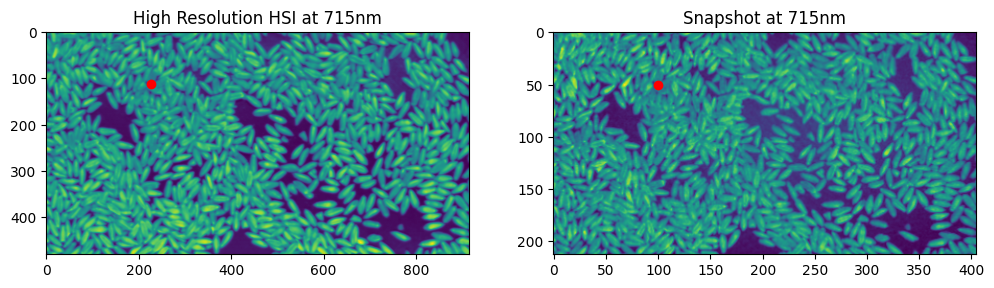

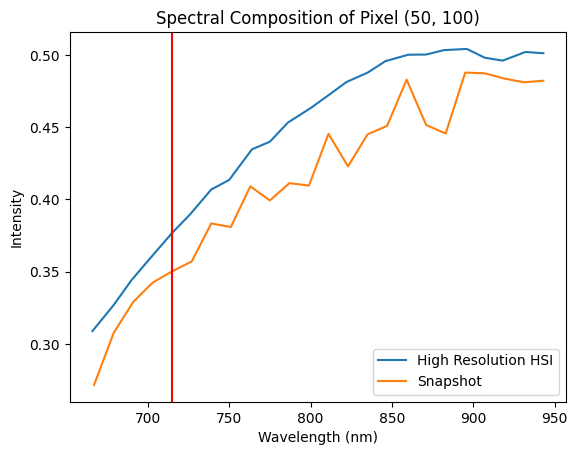

In [9]:
from align_images import plot_image_comparison

# Plot image comparison
plot_image_comparison(hr_img=hr_img, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(50, 100),
                      selected_spectrum=715)

In [9]:
print(ss_img.shape)
print(hr_img.shape)

(213, 405, 24)
(481, 915, 24)
